# Sentiment Analysis of Twitter Data in Python

we are going to perform the Sentiment Analysis of Twitter data live through Twitter’s API.

In [109]:
# import Libraries

import tweepy
import pandas as pd
import numpy as np
import string
import re

import preprocessor as p
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from textblob import TextBlob

import nltk
nltk.download('stopwords')


from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\waleed
[nltk_data]     traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Business Understanding

Twitter Sentiment Analysis helps to understand people’s views and feelings. It provides additional metrics to analyze the performance of products and services and provides opportunities for improvement.
 
We are going to perform these tasks :

 
1) Scraping tweets through Twitter's tweepy API

2) Categorizing tweets regarding their sentiments (positive, negative, or neutral).
 
3) Examining tweets sentiments with a word cloud 

4) Analyzing hashtags in tweets in bar graph 
 

# 2) Data Understanding

## Gathering Data

In [221]:
# twitter App access keys for @user
 
# Consumer
CONSUMER_KEY    = 'xxxxxxxxxxxxxxxxxxxx'
CONSUMER_SECRET = 'xxxxxxxxxxxxxxxxxxxx'
 
# Access:
ACCESS_TOKEN  = 'xxxxxxxxxxxxxxxxxxxx'
ACCESS_SECRET = 'xxxxxxxxxxxxxxxxxxxx'

In [129]:
def app_auth():
    
    """
    Authenticate our program using the credentials,
    then create a Twitter API object with the credentials
    """
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

## Access 

### 1) Scraping tweets through Twitter's tweepy API

In [130]:
tweet_extract = app_auth()

# input for term to be searched and how many tweets to search

search_term = input("Enter keyword or tag to search: ")
no_of_terms = int(input("Enter no: of tweets to search:"))

tweets = tweet_extract.user_timeline(screen_name = search_term, count = no_of_terms)
print('')
print("Number of tweets extracted: {}.\n".format(len(tweets)))

Enter keyword or tag to search: WHO
Enter no: of tweets to search:200

Number of tweets extracted: 200.



In [131]:
# display top 10 tweets

print("10 latest tweets are :\n")
for tweet in tweets[:10]:
    print(tweet.text)
    print('\n')

10 latest tweets are :

The #coronavirus has demonstrated the essential value of #HealthForAll and this is where we need full solidarity.… https://t.co/0N6DuhBihO


We fully support the initiative by WHO with other govts in assisting developing countries.
#SouthAfrica is particip… https://t.co/7VDCU1pIoo


Africa affirms its full support for WHO, which has been key in guiding the intl response to the #COVID19 pandemic.… https://t.co/2g2I7ND0sT


Need to accept the reality that this #coronavirus will be with us for some time. The social distancing hygiene &amp; ot… https://t.co/b9TlKDhLZz


Who is WHO?
The World Health Organization (WHO) is the @UN's specialized agency for health, governed by 194 Member… https://t.co/STv2EvESPt


The #COVID19 pandemic has highlighted the dangerous &amp; growing inequalities that exists between countries and within… https://t.co/yIAUeF6nXt


Appreciation to @DrTedros &amp; WHO for the appointment of Andrew Witty &amp; @NOIweala for the access to #COVID19

### Data is noisy contain links, spaces, special cheracters, hashtags etc.

In [132]:
# Creating a DataFrame of fetch tweets

df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
df['ID'] = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])
display(df.head(10))

,Tweets,ID,Date,Source,Likes,Retweets
0,The #coronavirus has demonstrated the essentia...,1262510341830971392,2020-05-18 22:28:16,Twitter for iPhone,59,17
1,We fully support the initiative by WHO with ot...,1262509997965086723,2020-05-18 22:26:54,Twitter for iPhone,57,15
2,"Africa affirms its full support for WHO, which...",1262506837359972352,2020-05-18 22:14:20,Twitter for iPhone,69,22
3,Need to accept the reality that this #coronavi...,1262497518656598016,2020-05-18 21:37:19,Twitter for iPhone,158,76
4,Who is WHO?\nThe World Health Organization (WH...,1262497012227899396,2020-05-18 21:35:18,Twitter for iPhone,75,24
5,The #COVID19 pandemic has highlighted the dang...,1262495494376435712,2020-05-18 21:29:16,Twitter for iPhone,155,56
6,Appreciation to @DrTedros &amp; WHO for the ap...,1262495134417117187,2020-05-18 21:27:50,Twitter for iPhone,103,34
7,#COVID19 has brought many of us closer than we...,1262494786109485059,2020-05-18 21:26:27,Twitter for iPhone,62,27
8,#Barbados investment in &amp; preparedness of ...,1262494179936145409,2020-05-18 21:24:03,Twitter for iPhone,47,18
9,Health is such a precious commodity. Healthy p...,1262492776224227336,2020-05-18 21:18:28,Twitter for iPhone,104,32


### Visualization and basic stats 

Creation of content sources:
* Twitter for iPhone
* Twitter Web App
* Periscope


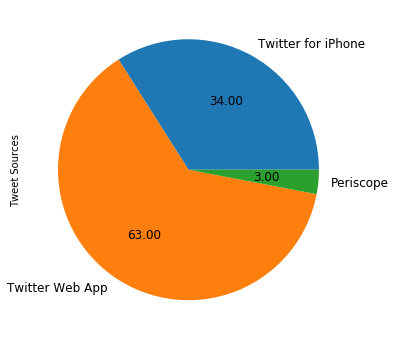

In [133]:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)
        
        
# We print sources list:

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

# We create a numpy vector mapped to labels:

percent = np.zeros(len(sources))
 
for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100
    
# Pie chart:

pie_chart = pd.Series(percent, index=sources, name='Tweet Sources')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(6, 6));

In [134]:
# Create a series from array
tweets_liked = pd.Series(data = df['Likes'].values)   
tweets_retweeted = pd.Series(data = df['Retweets'].values) 

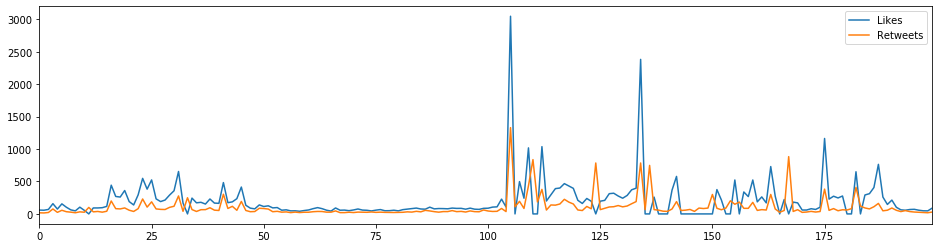

In [135]:
# Likes vs retweets visualization:

tweets_liked.plot(figsize=(16,4), label="Likes", legend=True)
tweets_retweeted.plot(figsize=(16,4), label="Retweets", legend=True)

# 3) Data Preparation

## Clean

Here we are going to clean our Tweets. We are going to: 

1) Remove Links 

2) Special Characters 

3) Remove spaces etc


In [212]:
def clean_tweet(tweet):
    
    """
     Clean data by remove Links, Special Characters etc from tweet
    """
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

for tweet in tweets[:10]:
    print(clean_tweet(tweet.text))
    print('\n')

The coronavirus has demonstrated the essential value of HealthForAll and this is where we need full solidarity


We fully support the initiative by WHO with other govts in assisting developing countries SouthAfrica is particip


Africa affirms its full support for WHO which has been key in guiding the intl response to the COVID19 pandemic


Need to accept the reality that this coronavirus will be with us for some time The social distancing hygiene amp ot


Who is WHO The World Health Organization WHO is the UN s specialized agency for health governed by 194 Member


The COVID19 pandemic has highlighted the dangerous amp growing inequalities that exists between countries and within


Appreciation to DrTedros amp WHO for the appointment of Andrew Witty amp NOIweala for the access to COVID19 tools ac


COVID19 has brought many of us closer than we have ever been with each other It has equally cast the brighter lig


Barbados investment in amp preparedness of public health officials over t

# 4) Data Modeling

In [213]:
# creating some variables and list to store info

polarity = 0
positive = 0
negative = 0
neutral = 0
        
positive_word = []
negtive_word = []

#tweets = []
tweet_text = []

# iterating through tweets fetched
for tweet in tweets:
    
    #Append to temp so that we can store in csv later. I use encode UTF-8
    tweet_text.append(clean_tweet(tweet.text).encode('utf-8'))
    
    # print (tweet.text.translate(non_bmp_map))    #print tweet's text
    analysis = TextBlob(tweet.text)
    
    # print(analysis.sentiment)  # print tweet's polarity
    polarity += analysis.sentiment.polarity
    
    # adding reaction of how people are reacting to find average later
    
    if (analysis.sentiment.polarity == 0): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0 ):
        positive_word.append(tweet.text)
        positive += 1
    elif (analysis.sentiment.polarity < 0):
        negtive_word.append(tweet.text)
        negative += 1

## Analyze

### 2-  Categorizing tweets regarding their sentiments (positive, negative or neutral).

In [214]:
def calculate_percentage(part, whole):
    
    """
    Calculate percentage of tweets polarity
    
    """
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')


# finding average of people's sentiments

positive = calculate_percentage(positive, no_of_terms)
negative = calculate_percentage(negative, no_of_terms)
neutral = calculate_percentage(neutral, no_of_terms)

print("Classification of tweets according to the sentments.\n")
print("Percentage of positive tweets: {}%".format(positive))
print("Percentage of neutral tweets: {}%".format(negative))
print("Percentage de negative tweets: {}%".format(neutral))

Classification of tweets according to the sentments.

Percentage of positive tweets: 48.00%
Percentage of neutral tweets: 10.50%
Percentage de negative tweets: 41.50%


# 5) Evaluation and Results

## Visualize 

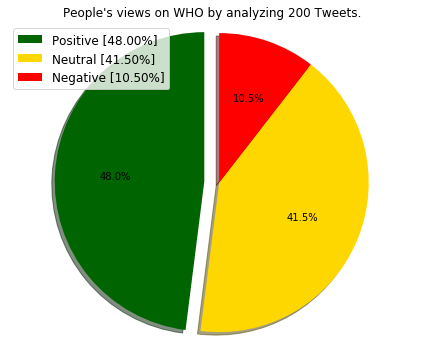

In [215]:
def plot_chart(positive, neutral, negative, search_term, no_of_terms):
    
    """
    Draw pie chart showing classification of sentimets 
    """
     
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['darkgreen', 'gold', 'red']
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.pie(sizes,colors= colors, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(labels, loc="upper left" , prop={'size': 12})
    plt.title('People\'s views on ' + search_term + ' by analyzing ' + str(no_of_terms) + ' Tweets.')
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    

plot_chart(positive, neutral, negative, search_term, no_of_terms)

### 3-  Examining hashtags in tweets in bar graph 

In [216]:
def extract_hashtags(tweets):
    
    """
    Collect hashtags from tweets list by find tweets 
    that start with #
    """
    
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet.text)
        hashtags.append(hashtag)

    return hashtags

# extracting hashtags from tweets
hashtag = extract_hashtags(tweets)

# unnesting list
hashtag = sum(hashtag,[])

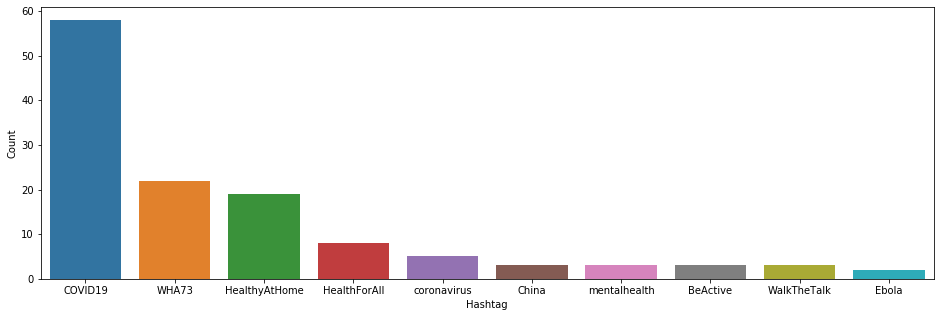

In [217]:
a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### 4- Examining tweets sentiments with word cloud 

In [218]:
def draw_wordcloud(tweets, color = 'black'):
    
    """
    Draw a cloud a word from tweets 
    """
    words = ' '.join(tweets)
    cleaned_word = " ".join([word for word in words.split() 
                             if 'http' not in word
                                    and not word.startswith('@')
                                    and not word.startswith('#')
                                    and word != 'RT'
                            ])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          max_words=100,
                          width=3000,
                          height=1000
                         ).generate(cleaned_word)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

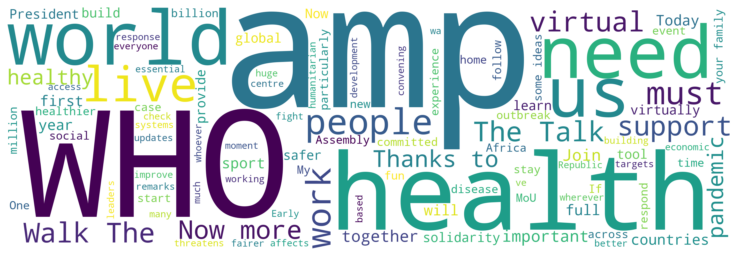

In [219]:
# call function to draw word of cloud with positve sentiments 

draw_wordcloud(positive_word, 'white')

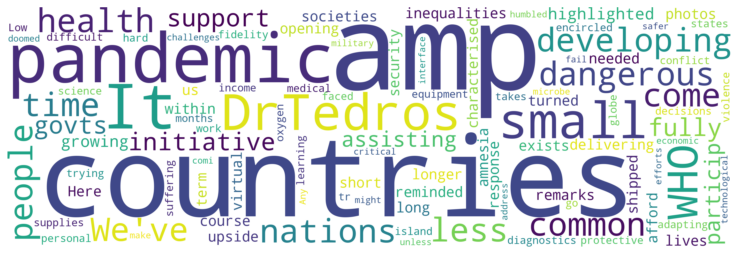

In [220]:
# call function to draw word of cloud with negitive sentiments

draw_wordcloud(negtive_word,'white')